In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tfds.disable_progress_bar()

In [3]:
# Exemplar Embedding Layer

embedding_layer = layers.Embedding(1000, 5)

result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.03340373, -0.04612683,  0.0446387 ,  0.04017072,  0.02907497],
       [-0.02218298, -0.03488926, -0.04353002,  0.00954001,  0.03057602],
       [-0.03357098, -0.01731163, -0.04456203,  0.03470374,  0.04916837]],
      dtype=float32)

In [4]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [5]:
# Load the data

(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info = True, as_supervised = True)

In [6]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [7]:
train_data

<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [8]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = ([None],[]))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = ([None],[]))

In [9]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 519,  198,   46, ...,    0,    0,    0],
       [ 249,    4, 7510, ...,    0,    0,    0],
       [ 597, 4246,   41, ..., 7725,  100, 7962],
       ...,
       [8002, 7968,  111, ...,    0,    0,    0],
       [ 147,    1, 5302, ...,    0,    0,    0],
       [  12,  258,    4, ...,    0,    0,    0]])

In [10]:
# Model

embedding_dim = 16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation = 'relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile and Train Model

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

history = model.fit(
    train_batches,
    epochs = 10,
    validation_data = test_batches, validation_steps = 20)

Epoch 1/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.4991 - accuracy: 0.7038 - val_loss: 0.4243 - val_accuracy: 0.7450
Epoch 2/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2798 - accuracy: 0.8861 - val_loss: 0.2642 - val_accuracy: 0.8950
Epoch 3/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2266 - accuracy: 0.9100 - val_loss: 0.3135 - val_accuracy: 0.8600
Epoch 4/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1945 - accuracy: 0.9263 - val_loss: 0.4947 - val_accuracy: 0.7700
Epoch 5/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1729 - accuracy: 0.9359 - val_loss: 0.2826 - val_accuracy: 0.8850
Epoch 6/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1539 - accuracy: 0.9433 - val_loss: 0.3529 - val_accuracy: 0.8550
Epoch 7/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.1411 - accuracy: 0.9482 - val_loss: 0.3074 - val_ac

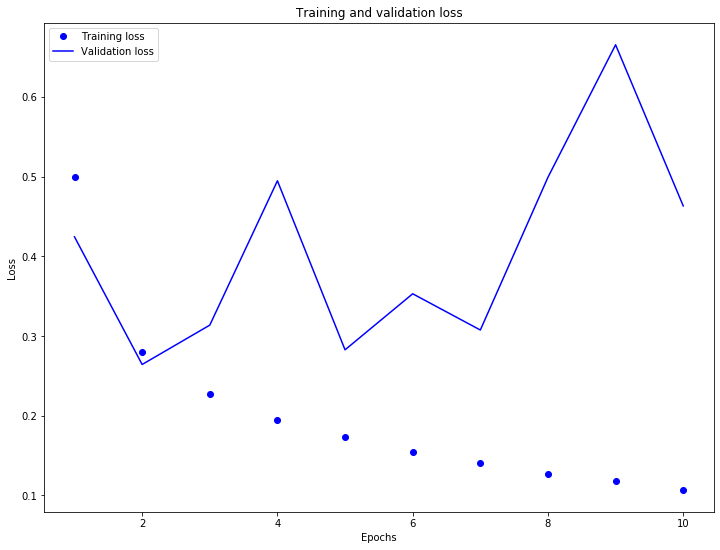

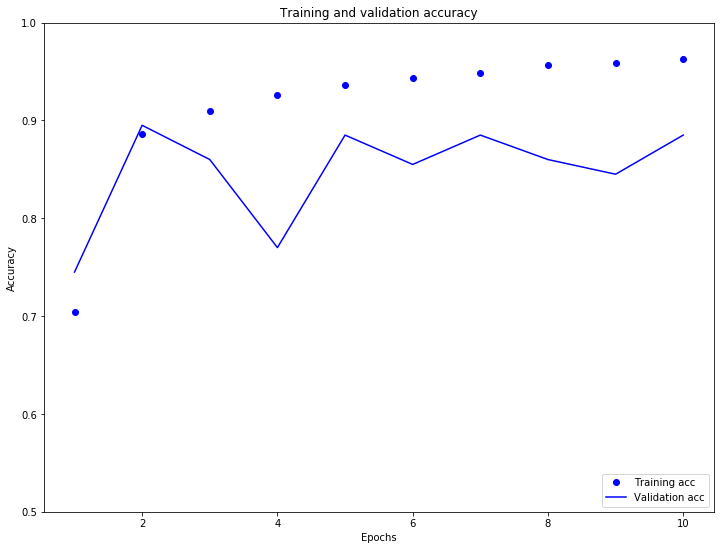

In [12]:
# Plot Metrics

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12,9))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize = (12,9))
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim((0.5,1))
plt.show()

In [13]:
# Retrieve the word embeddings

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [14]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding = 'utf-8')
out_m = io.open('meta.tsv', 'w', encoding = 'utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# Visualize the embeddings

